In [1]:
import pickle
from pathlib import Path
import numpy as np
import statistics
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *

In [88]:
import pickle
from pathlib import Path
import numpy as np
import statistics

def convert_to_float(value):
    """Convert NumPy arrays or other numeric types to float or list of floats."""
    if isinstance(value, np.ndarray):
        return [float(f"{x:.13f}") for x in value]
    elif isinstance(value, (float, int, np.float32, np.float64, np.int32, np.int64)):
        return float(f"{value:.13f}")
    else:
        return value

def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    
    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        #if fixed_params_dict == 'fixed_params2':
        #    continue
        print(fixed_params_dict)
        for trainable_params_dict in df[fixed_params_dict].keys():
            # if trainable_params_dict == 'test20' or trainable_params_dict == 'test52':
            #     continue
            if trainable_params_dict == 'test0':
                print(trainable_params_dict, df[fixed_params_dict][trainable_params_dict]['K_coeffs'])
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict

def get_jacobian(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    jacobian_dict = {}
    for fixed_params_dict in df.keys():
        #if fixed_params_dict == 'fixed_params2':
        #    continue
        for trainable_params_dict in df[fixed_params_dict].keys():
            #if trainable_params_dict == 'test14' or trainable_params_dict == 'test48':
             #   continue
            results = df[fixed_params_dict][trainable_params_dict]
            if 'jacobian' in results:
                jacobian = results['jacobian']
                if fixed_params_dict not in jacobian_dict:
                    jacobian_dict[fixed_params_dict] = {}
                jacobian_dict[fixed_params_dict][trainable_params_dict] = jacobian

    return jacobian_dict


def get_entropy(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    entropy_dict = {}
    for fixed_params_dict in df.keys():
        #if fixed_params_dict == 'fixed_params2':
        #    continue
        for trainable_params_dict in df[fixed_params_dict].keys():
            #if trainable_params_dict == 'test14' or trainable_params_dict == 'test48':
             #   continue
            results = df[fixed_params_dict][trainable_params_dict]
            
            if 'entropy' in results:
                entropy = results['entropy']
                # print(entropy)
                if fixed_params_dict not in entropy_dict:
                    entropy_dict[fixed_params_dict] = {}
                entropy_dict[fixed_params_dict][trainable_params_dict] = entropy

    return entropy_dict
def find_jacobian_variance_extremes(jacobian_dict):
    min_var_val = float('inf')
    max_var_val = float('-inf')

    min_var_params = None
    max_var_params = None

    for fixed_param, trainable_dict in jacobian_dict.items():
        for trainable_param, jacobian in trainable_dict.items():
            variance = np.var(jacobian)

            if variance < min_var_val:
                min_var_val = variance
                min_var_params = (fixed_param, trainable_param)

            if variance > max_var_val:
                max_var_val = variance
                max_var_params = (fixed_param, trainable_param)

    return {
        "min_jacobian_variance": (min_var_params, min_var_val),
        "max_jacobian_variance": (max_var_params, max_var_val)
    }
def find_extreme_params(qfim_eigvals_dict):
    min_trace_val = float('inf')
    max_trace_val = float('-inf')
    min_var_val = float('inf')
    max_var_val = float('-inf')

    min_trace_params = None
    max_trace_params = None
    min_var_params = None
    max_var_params = None

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            trace = np.sum(eigvals)
            variance = np.var(eigvals)

            if trace < min_trace_val:
                min_trace_val = trace
                min_trace_params = (fixed_param, trainable_param)

            if trace > max_trace_val:
                max_trace_val = trace
                max_trace_params = (fixed_param, trainable_param)

            if variance < min_var_val:
                min_var_val = variance
                min_var_params = (fixed_param, trainable_param)

            if variance > max_var_val:
                max_var_val = variance
                max_var_params = (fixed_param, trainable_param)

    return {
        "min_trace": (min_trace_params, min_trace_val),
        "max_trace": (max_trace_params, max_trace_val),
        "min_variance": (min_var_params, min_var_val),
        "max_variance": (max_var_params, max_var_val)
    }

def find_average_extreme_params(qfim_eigvals_dict):
    avg_trace_dict = {}
    avg_var_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        traces = [np.sum(eigvals) for eigvals in trainable_dict.values()]
        variances = [np.var(eigvals) for eigvals in trainable_dict.values()]

        avg_trace_dict[fixed_param] = np.mean(traces)
        avg_var_dict[fixed_param] = np.mean(variances)

    min_avg_trace_val = min(avg_trace_dict.values())
    max_avg_trace_val = max(avg_trace_dict.values())
    min_avg_var_val = min(avg_var_dict.values())
    max_avg_var_val = max(avg_var_dict.values())

    min_avg_trace_key = min(avg_trace_dict, key=avg_trace_dict.get)
    max_avg_trace_key = max(avg_trace_dict, key=avg_trace_dict.get)
    min_avg_var_key = min(avg_var_dict, key=avg_var_dict.get)
    max_avg_var_key = max(avg_var_dict, key=avg_var_dict.get)

    return {
        "avg_trace_dict": avg_trace_dict,
        "avg_var_dict": avg_var_dict,
        "min_avg_trace": (min_avg_trace_key, min_avg_trace_val),
        "max_avg_trace": (max_avg_trace_key, max_avg_trace_val),
        "min_avg_variance": (min_avg_var_key, min_avg_var_val),
        "max_avg_variance": (max_avg_var_key, max_avg_var_val)
    }

def find_range_extreme_params(qfim_eigvals_dict):
    trace_range_dict = {}
    var_range_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        traces = [np.sum(eigvals) for eigvals in trainable_dict.values()]
        variances = [np.var(eigvals) for eigvals in trainable_dict.values()]

        trace_range_dict[fixed_param] = max(traces) - min(traces)
        var_range_dict[fixed_param] = max(variances) - min(variances)

    min_trace_range_val = min(trace_range_dict.values())
    max_trace_range_val = max(trace_range_dict.values())
    min_var_range_val = min(var_range_dict.values())
    max_var_range_val = max(var_range_dict.values())

    min_trace_range_key = min(trace_range_dict, key=trace_range_dict.get)
    max_trace_range_key = max(trace_range_dict, key=trace_range_dict.get)
    min_var_range_key = min(var_range_dict, key=var_range_dict.get)
    max_var_range_key = max(var_range_dict, key=var_range_dict.get)

    return {
        "trace_range_dict": trace_range_dict,
        "var_range_dict": var_range_dict,
        "min_trace_range": (min_trace_range_key, min_trace_range_val),
        "max_trace_range": (max_trace_range_key, max_trace_range_val),
        "min_variance_range": (min_var_range_key, min_var_range_val),
        "max_variance_range": (max_var_range_key, max_var_range_val)
    }
def calculate_combined_score(avg_dict, range_dict, weight_avg=0.5, weight_range=0.5):
    """
    Calculate a combined score for each fixed parameter based on average and range values.
    The score is a weighted sum of normalized average and range values.
    """
    avg_values = list(avg_dict.values())
    range_values = list(range_dict.values())

    max_avg = max(avg_values)
    min_avg = min(avg_values)
    max_range = max(range_values)
    min_range = min(range_values)

    combined_scores = {}
    for key in avg_dict.keys():
        normalized_avg = (avg_dict[key] - min_avg) / (max_avg - min_avg)
        normalized_range = (range_dict[key] - min_range) / (max_range - min_range)
        combined_score = weight_avg * normalized_avg - weight_range * normalized_range
        combined_scores[key] = combined_score

    return combined_scores



# Example usage
N_ctrl = 2
Nr = 2
trotter_step = 10
num_L = 100
state = 'GHZ'
kfactor = 0.1
# base_path = f'/Users/so714f/Documents/offline/qrc/QFIM_traced_final_results/gate_model_hZ_DQFIM/Nc_{N_ctrl}/L_{num_L}/{kfactor}xK/2pi_E_0/'
base_path = f'/Users/so714f/Documents/offline/qrc/gate_model_theorem23_eigval_decomp/Nc_{N_ctrl}/GHZ_state/{kfactor}xK/'
sample_range_label = 'pi'

# file_path = Path(base_path) / f'Nr_{Nr}' / f'trotter_step_{trotter_step}' / f'L_{num_L}/data_{sample_range_label}_range.pickle'

file_path = Path(base_path) / f'Nr_{Nr}' / f'trotter_step_{trotter_step}' / f'data.pickle'

# /Users/so714f/Documents/offline/qrc/gate_model_theorem23_eigval_decomp/Nc_2/GHZ_state/0.1xK/Nr_3/trotter_step_1/data.pickle


qfim_eigvals_dict = get_qfim_eigvals(file_path)
# print(qfim_eigvals_dict['fixed_params0']['test250'])
jacobian_dict = get_jacobian(file_path)
entropy_dict = get_entropy(file_path)
print(qfim_eigvals_dict.keys())

fixed_params0
test0 [[-0.05338911  0.07832897  0.04906414 -0.05006148]
 [ 0.07832897 -0.05391157  0.04889255  0.07848373]
 [ 0.04906414  0.04889255 -0.1060942  -0.00697697]
 [-0.05006148  0.07848373 -0.00697697 -0.2588982 ]]
fixed_params1
test0 [[-0.06404524 -0.0858328   0.01750791 -0.01489758]
 [-0.0858328   0.13908187 -0.00634736 -0.04747433]
 [ 0.01750791 -0.00634736 -0.00826747  0.09771219]
 [-0.01489758 -0.04747433  0.09771219 -0.05307522]]
fixed_params2
test0 [[ 0.05628164  0.06964562 -0.06682549  0.04105155]
 [ 0.06964562  0.04260541 -0.13272579 -0.10630423]
 [-0.06682549 -0.13272579  0.02307615 -0.00820222]
 [ 0.04105155 -0.10630423 -0.00820222  0.01768232]]
fixed_params3
test0 [[ 0.08995284 -0.00066985 -0.04505502 -0.05725664]
 [-0.00066985 -0.16955128 -0.02917114  0.1108336 ]
 [-0.04505502 -0.02917114  0.01201474 -0.05318568]
 [-0.05725664  0.1108336  -0.05318568 -0.20845924]]
fixed_params4
test0 [[ 0.26865628 -0.01542855  0.10713954 -0.00680958]
 [-0.01542855 -0.1885799   0.

In [79]:

if qfim_eigvals_dict is not None:
    results = find_extreme_params(qfim_eigvals_dict)
    print(f"Minimum trace: {results['min_trace']}")
    print(f"Maximum trace: {results['max_trace']}")
    print(f"Minimum variance: {results['min_variance']}")
    print(f"Maximum variance: {results['max_variance']}")

    avg_results = find_average_extreme_params(qfim_eigvals_dict)
    print(f"Minimum average trace: {avg_results['min_avg_trace']}")
    print(f"Maximum average trace: {avg_results['max_avg_trace']}")
    print(f"Minimum average variance: {avg_results['min_avg_variance']}")
    print(f"Maximum average variance: {avg_results['max_avg_variance']}")

    range_results = find_range_extreme_params(qfim_eigvals_dict)
    print(f"Minimum trace range: {range_results['min_trace_range']}")
    print(f"Maximum trace range: {range_results['max_trace_range']}")
    print(f"Minimum variance range: {range_results['min_variance_range']}")
    print(f"Maximum variance range: {range_results['max_variance_range']}")

    combined_trace_scores = calculate_combined_score(avg_results['avg_trace_dict'], range_results['trace_range_dict'])
    combined_variance_scores = calculate_combined_score(avg_results['avg_var_dict'], range_results['var_range_dict'])

    best_trace_param = max(combined_trace_scores, key=combined_trace_scores.get)
    best_variance_param = max(combined_variance_scores, key=combined_variance_scores.get)

    print(f"\nBest fixed parameter for trace optimization: {best_trace_param}")
    print(f"Best fixed parameter for variance optimization: {best_variance_param}")

    best_trace_param_min = min(combined_trace_scores, key=combined_trace_scores.get)
    best_variance_param_min = min(combined_variance_scores, key=combined_variance_scores.get)

    print(f"\nBest fixed parameter for trace optimization: {best_trace_param_min}")
    print(f"Best fixed parameter for variance optimization: {best_variance_param_min}")
    jacobian_variance_extremes = find_jacobian_variance_extremes(jacobian_dict)
    print(f"Minimum Jacobian variance: {jacobian_variance_extremes['min_jacobian_variance']}")
    print(f"Maximum Jacobian variance: {jacobian_variance_extremes['max_jacobian_variance']}")

def find_fixed_param_with_smallest_max_trace(qfim_eigvals_dict):
    smallest_max_trace = float('inf')
    best_fixed_param = None

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        max_trace = float('-inf')
        for eigvals in trainable_dict.values():
            trace = np.sum(eigvals)
            if trace > max_trace:
                max_trace = trace
        
        if max_trace < smallest_max_trace:
            smallest_max_trace = max_trace
            best_fixed_param = fixed_param

    return best_fixed_param, smallest_max_trace
def find_fixed_param_with_largest_min_trace(qfim_eigvals_dict):
    largest_min_trace = float('-inf')
    best_fixed_param = None

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        min_trace = float('inf')
        for eigvals in trainable_dict.values():
            trace = np.sum(eigvals)
            if trace < min_trace:
                min_trace = trace
        
        if min_trace > largest_min_trace:
            largest_min_trace = min_trace
            best_fixed_param = fixed_param


    return best_fixed_param, largest_min_trace

if qfim_eigvals_dict is not None:
    best_fixed_param_largest_min, largest_min_trace = find_fixed_param_with_largest_min_trace(qfim_eigvals_dict)
    print(f"\n\nBest fixed parameter set with largest minimum trace: {best_fixed_param_largest_min}")
    print(f"Largest minimum trace: {largest_min_trace}")

    best_fixed_param_smallest_max, smallest_max_trace = find_fixed_param_with_smallest_max_trace(qfim_eigvals_dict)
    print(f"Best fixed parameter set with smallest maximum trace: {best_fixed_param_smallest_max}")
    print(f"Smallest maximum trace: {smallest_max_trace}")
#./QFIM_traced_final_results/gate_model_DQFIM/Nc_2/L_100/1xK/Nr_1/trotter_step_10/L_100
# ./QFIM_traced_final_results/gate_model_DQFIM/Nc_2/L_100/1xK/Nr_1/trotter_step_10/L_100/data_pi_range.pickle

Minimum trace: (('fixed_params2', 'test33'), Array(1.1412051, dtype=float32))
Maximum trace: (('fixed_params2', 'test74'), Array(20.921955, dtype=float32))
Minimum variance: (('fixed_params2', 'test33'), Array(0.01281882, dtype=float32))
Maximum variance: (('fixed_params2', 'test74'), Array(16.63577, dtype=float32))
Minimum average trace: ('fixed_params2', np.float32(3.6681712))
Maximum average trace: ('fixed_params7', np.float32(4.349592))
Minimum average variance: ('fixed_params14', np.float32(0.42348137))
Maximum average variance: ('fixed_params7', np.float32(0.6014731))
Minimum trace range: ('fixed_params8', Array(12.760229, dtype=float32))
Maximum trace range: ('fixed_params2', Array(19.78075, dtype=float32))
Minimum variance range: ('fixed_params8', Array(6.206334, dtype=float32))
Maximum variance range: ('fixed_params2', Array(16.622952, dtype=float32))

Best fixed parameter for trace optimization: fixed_params8
Best fixed parameter for variance optimization: fixed_params8

Best

In [3]:
entropy_dict = get_entropy(file_path)
entropy_dict

{}

In [64]:
import jax.numpy as jnp
def process_qfim_eigvals(qfim_eigvals_dict, threshold=1e-12, alpha=0.75):
    # Create a new dictionary to store processed values
    processed_qfim_dict = {}

    for fixed_params, test_results in qfim_eigvals_dict.items():
        nonzero_eigvals,all_eigvals = [],[]
        
        # Iterate over tests and collect eigenvalues
        for test, eigvals in test_results.items():
            # Apply threshold and compute mean along eigenvalue axis
            eigvals = np.array(eigvals)
            all_eigvals.append(np.array(np.where(eigvals < threshold, 0, eigvals)))
            nonzero_eigvals.append(np.array([val for val in eigvals if val > threshold]))
        nonzero_eigvals = np.array(nonzero_eigvals)
        all_eigvals = np.array(all_eigvals)
        # Compute the mean of all tests' averaged eigenvalues
        avg_qfim_eigvals = np.mean(all_eigvals, axis=0)
        
        test_var_qfim_eigvals =  jnp.var(jnp.asarray(all_eigvals), axis=0, ddof=1)
        per_test_var_qfim_eigvals =  jnp.var(jnp.asarray(all_eigvals), axis=1, ddof=1)
        # df_all['test_var_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
        #     lambda eigval_list: [np.var(np.where(np.array(eigvals) < threshold, 0, eigvals)) for eigvals in eigval_list]
        # )
        per_test_trace_qfim = np.mean(all_eigvals, axis=1)
        # print(per_test_trace_qfim.shape)
        
        trace_avg_eigvals = sum(avg_qfim_eigvals)
        # Apply power scaling
        power_scaled_avg_qfim_eigvals = avg_qfim_eigvals ** alpha

        power_scaled_avg_qfim_eigvals_nonzero = np.array([val for val in avg_qfim_eigvals if val > threshold]) ** alpha

        
        
        # Save both the averaged and power-scaled values
        processed_qfim_dict[fixed_params] = {
            'test_var_qfim_eigvals':test_var_qfim_eigvals,
            'per_test_var_qfim_eigvals':per_test_var_qfim_eigvals,
            'avg(var) [avg eigvals]':test_var_qfim_eigvals.mean(),
            'avg(var) [per test]':per_test_var_qfim_eigvals.mean(),
            'Var(Var) [per test]': np.var(per_test_var_qfim_eigvals),
            'Var(Tr) [per test]': np.var(per_test_trace_qfim),
            'avg_qfim_eigvals': avg_qfim_eigvals,
            'power_scaled_avg_qfim_eigvals': power_scaled_avg_qfim_eigvals,
            'power_scaled_avg_qfim_eigvals_nonzero': power_scaled_avg_qfim_eigvals_nonzero,
            'var_power_scaled_avg_qfim_eigvals': np.var(power_scaled_avg_qfim_eigvals),

            'var_power_scaled_avg_qfim_eigvals_nonzero': np.var(power_scaled_avg_qfim_eigvals_nonzero),
            'trace_avg_eigvals':trace_avg_eigvals,


        }

    return processed_qfim_dict
# print(len(qfim_eigvals_dict['fixed_params0'].values()))
# Process the eigenvalues
processed_qfim_dict = process_qfim_eigvals(qfim_eigvals_dict)

# Convert to DataFrame for visualization
df_all = pd.DataFrame(processed_qfim_dict)

# Display DataFrame
df_all


,fixed_params0,fixed_params1,fixed_params2,fixed_params3,fixed_params4,fixed_params5,fixed_params6,fixed_params7,fixed_params8,fixed_params9
test_var_qfim_eigvals,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.8310917e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.267556e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4026958e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.535532e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.9402505e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.7998435e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9077833e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3644412e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.2255446e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.030559e-..."
per_test_var_qfim_eigvals,"[37.730473, 4.319466, 7.3878465, 0.074541636, ...","[4.109318, 1.1255661, 0.90252876, 0.80116135, ...","[10.393319, 1.8613038, 1.4528095, 0.0271785, 0...","[18.40018, 2.0366993, 2.7638311, 0.027287314, ...","[3.587378, 1.6139425, 0.7155759, 0.02599351, 0...","[43.093864, 3.6014247, 9.050985, 0.04164247, 0...","[6.484637, 1.7588383, 1.0227685, 0.026638962, ...","[1.5657681, 0.6084451, 0.54078674, 1.0103695, ...","[42.913315, 3.4229426, 9.002897, 0.037710607, ...","[2.8168046, 0.82031584, 0.7689944, 0.9038499, ..."
avg(var) [avg eigvals],1.8669406,0.66570634,0.8134571,1.0736419,0.63277394,2.0011034,0.70337886,0.5933653,1.9869334,0.6324917
avg(var) [per test],4.0437827,1.6134073,1.9492702,2.4782476,1.5180632,4.2755723,1.7116926,1.3362154,4.2453403,1.4921224
Var(Var) [per test],50.090225,7.9911404,12.300624,19.618498,7.771752,58.04414,9.454777,8.130626,57.23748,8.083236
Var(Tr) [per test],0.093713,0.03232,0.039731,0.053537,0.030117,0.101429,0.033911,0.028574,0.100804,0.030584
avg_qfim_eigvals,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.703157e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0056992e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0596277e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.857273e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.460586e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0211097e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.281105e-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.29764e-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.2087457e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1153969e..."
power_scaled_avg_qfim_eigvals,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010099...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00017858...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00018572...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00014840...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00023626...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010607...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00021413...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00021620...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00010903...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00019300..."
power_scaled_avg_qfim_eigvals_nonzero,"[0.000100993195, 0.0003087192, 0.00071325374, ...","[0.0001785875, 0.00048546537, 0.0010830966, 0....","[0.0001857227, 0.00048464714, 0.0010715473, 0....","[0.00014840683, 0.0004157912, 0.00093140604, 0...","[0.0002362628, 0.0005520763, 0.0013105499, 0.0...","[0.00010607176, 0.00031952222, 0.0007084705, 0...","[0.00021413543, 0.00051869446, 0.0011995161, 0...","[0.00021620496, 0.00055395655, 0.001270507, 0....","[0.00010903097, 0.00032218648, 0.000720115, 0....","[0.00019300656, 0.000513899, 0.0011527096, 0.0..."
var_power_scaled_avg_qfim_eigvals,0.809202,0.434748,0.497454,0.58323,0.413004,0.836567,0.455002,0.362995,0.832198,0.404385


In [7]:
entropy_dict.keys()

dict_keys([])

In [57]:
# Convert the processed dictionary into a DataFrame for easier operations
df_all = pd.DataFrame(processed_qfim_dict).T  # Transpose for easier access

# Now find the min/max keys for both var_power_scaled_avg_qfim_eigvals and var_power_scaled_avg_qfim_eigvals_nonzero
min_var_qfim_key = df_all['var_power_scaled_avg_qfim_eigvals'].idxmin(), df_all['var_power_scaled_avg_qfim_eigvals'].min()
max_var_qfim_key = df_all['var_power_scaled_avg_qfim_eigvals'].idxmax(), df_all['var_power_scaled_avg_qfim_eigvals'].max()

min_power_var_qfim_nonzero_key = df_all['var_power_scaled_avg_qfim_eigvals_nonzero'].idxmin(), df_all['var_power_scaled_avg_qfim_eigvals_nonzero'].min()
max_power_qfim_nonzero_key = df_all['var_power_scaled_avg_qfim_eigvals_nonzero'].idxmax(), df_all['var_power_scaled_avg_qfim_eigvals_nonzero'].max()

# Nicely formatted output
print("Results for 'var_power_scaled_avg_qfim_eigvals':")
print(f"Minimum variance found for fixed parameter set: {min_var_qfim_key[0]}, with value: {min_var_qfim_key[1]:.5f}")
print(f"Maximum variance found for fixed parameter set: {max_var_qfim_key[0]}, with value: {max_var_qfim_key[1]:.5f}")

print("\nResults for 'var_power_scaled_avg_qfim_eigvals_nonzero':")
print(f"Minimum variance found for fixed parameter set: {min_power_var_qfim_nonzero_key[0]}, with value: {min_power_var_qfim_nonzero_key[1]:.5f}")
print(f"Maximum variance found for fixed parameter set: {max_power_qfim_nonzero_key[0]}, with value: {max_power_qfim_nonzero_key[1]:.5f}")



min_var_qfim_nonzero_key = df_all['avg(var) [per test]'].idxmin(), df_all['avg(var) [per test]'].min()
max_var_qfim_nonzero_key = df_all['avg(var) [per test]'].idxmax(), df_all['avg(var) [per test]'].max()

print(f"\nMinimum variance found for fixed parameter set: {min_var_qfim_nonzero_key[0]}, with value: {min_var_qfim_nonzero_key[1]:.5f}")
print(f"Maximum variance found for fixed parameter set: {max_var_qfim_nonzero_key[0]}, with value: {max_var_qfim_nonzero_key[1]:.5f}")


min_trace_qfim_nonzero_key = df_all['trace_avg_eigvals'].idxmin(), df_all['trace_avg_eigvals'].min()
max_trace_qfim_nonzero_key = df_all['trace_avg_eigvals'].idxmax(), df_all['trace_avg_eigvals'].max()


print("\nResults for 'minimum trace':")
print(f"Minimum variance found for fixed parameter set: {min_trace_qfim_nonzero_key[0]}, with value: {min_trace_qfim_nonzero_key[1]:.5f}")
print(f"Maximum variance found for fixed parameter set: {max_trace_qfim_nonzero_key[0]}, with value: {max_trace_qfim_nonzero_key[1]:.5f}")


Results for 'var_power_scaled_avg_qfim_eigvals':
Minimum variance found for fixed parameter set: fixed_params7, with value: 0.36300
Maximum variance found for fixed parameter set: fixed_params5, with value: 0.83657

Results for 'var_power_scaled_avg_qfim_eigvals_nonzero':
Minimum variance found for fixed parameter set: fixed_params7, with value: 0.50353
Maximum variance found for fixed parameter set: fixed_params5, with value: 1.17109

Minimum variance found for fixed parameter set: fixed_params7, with value: 1.33622
Maximum variance found for fixed parameter set: fixed_params5, with value: 4.27557

Results for 'minimum trace':
Minimum variance found for fixed parameter set: fixed_params7, with value: 5.25417
Maximum variance found for fixed parameter set: fixed_params5, with value: 8.66894


In [6]:
qfim_variances_by_fixedparam_dict = {}

for fp,eigs in qfim_eigvals_dict.items():

    qfim_variances_by_fixedparam_dict.setdefault(fp, {}).setdefault('avg_eigs', []).extend(eigs)
    # qfim_variances_by_fixedparam_dict.setdefault(fp, {}).setdefault('avg_eigs', []).extend(eigs)
df_all = pd.DataFrame(qfim_variances_by_fixedparam_dict)

In [7]:
def get_metrics(fixed_param_key, test_key, jacobian_dict, qfim_eigvals_dict):
    """
    Calculate the variance of the Jacobian, variance of the QFIM eigenvalues, and trace of the QFIM eigenvalues
    for a given fixed_param_key and test_key.

    Args:
        fixed_param_key (str): The key for the fixed parameters.
        test_key (str): The key for the trainable parameters (test).
        jacobian_dict (dict): The dictionary containing the Jacobian values.
        qfim_eigvals_dict (dict): The dictionary containing the QFIM eigenvalues.

    Returns:
        dict: A dictionary with the calculated metrics (Jacobian variance, QFIM variance, QFIM trace), or None if not found.
    """
    metrics = {}

    # Calculate Jacobian variance
    if fixed_param_key in jacobian_dict:
        if test_key in jacobian_dict[fixed_param_key]:
            jacobian = jacobian_dict[fixed_param_key][test_key]
            jacobian_variance = np.var(jacobian)
            metrics['jacobian_variance'] = jacobian_variance
        else:
            print(f"Test key {test_key} not found in fixed parameter key {fixed_param_key}.")
            metrics['jacobian_variance'] = None
    else:
        print(f"Fixed parameter key {fixed_param_key} not found in Jacobian dictionary.")
        metrics['jacobian_variance'] = None

    # Calculate QFIM eigenvalues variance and trace
    if fixed_param_key in qfim_eigvals_dict:
        if test_key in qfim_eigvals_dict[fixed_param_key]:
            qfim_eigvals = qfim_eigvals_dict[fixed_param_key][test_key]
            qfim_variance = np.var(qfim_eigvals)
            qfim_trace = np.sum(qfim_eigvals)
            metrics['qfim_variance'] = qfim_variance
            metrics['qfim_trace'] = qfim_trace
        else:
            print(f"Test key {test_key} not found in fixed parameter key {fixed_param_key} for QFIM eigenvalues.")
            metrics['qfim_variance'] = None
            metrics['qfim_trace'] = None
    else:
        print(f"Fixed parameter key {fixed_param_key} not found in QFIM eigenvalues dictionary.")
        metrics['qfim_variance'] = None
        metrics['qfim_trace'] = None

    return metrics

# Example usage
fixed_param_key = 'fixed_params1'
test_keys = ['test65', 'test3', 'test49', 'test97', 'test0']

for test_key in test_keys:
    metrics = get_metrics(fixed_param_key, test_key, jacobian_dict, qfim_eigvals_dict)
    #print(metrics)
    if metrics['jacobian_variance'] is not None:
        print(f"\nMetrics for {fixed_param_key} and {test_key}:")
        print(f"  Variance of the Jacobian: {metrics['jacobian_variance']:.13f}")
        print(f"  Variance of the QFIM eigenvalues: {metrics['qfim_variance']:.13f}")
        print(f"  Trace of the QFIM eigenvalues: {metrics['qfim_trace']:.13f}")

Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.
Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.
Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.
Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.
Fixed parameter key fixed_params1 not found in Jacobian dictionary.
Fixed parameter key fixed_params1 not found in QFIM eigenvalues dictionary.


In [8]:
threshold = 1e-14

def process_params(params):
    """Process a dictionary of parameters, converting all numeric values to floats or lists of floats."""
    #print(params)
    return {key: convert_to_float(value) for key, value in params.items()}
def convert_to_float(value):
    
    """Convert NumPy arrays or other numeric types to float or list of floats."""
    if isinstance(value, np.ndarray):
        # Convert NumPy array to list of floats
        return [float(f"{x:.13f}") for x in value]
    elif isinstance(value, (float, int, np.float32, np.float64, np.int32, np.int64)):
        # Convert single numeric value to float
        return float(f"{value:.13f}")
    else:
        # Return the value as-is if it's not a recognized numeric type
        return value
    
def convert_to_hashable(value):
    """Convert unhashable types (e.g., NumPy arrays) to hashable types (e.g., tuples)."""
    if isinstance(value, np.ndarray):
        return tuple(value.tolist())  # Convert arrays to tuples
    elif isinstance(value, list):
        return tuple(value)  # Convert lists to tuples
    else:
        return value

def process_params_for_hashing(params):
    """Process a dictionary of parameters, converting all values to hashable types."""
    return {key: convert_to_hashable(value) for key, value in params.items()}

some_results = {}


def find_max_variance_params(file_path,track):
    """
    Load data from a pickle file and find the parameters with the maximum mean variance of the qfim eigenvalues.

    Parameters:
    - file_path: Path object or str, the path to the pickle file.
    - metric: str, the metric to compare, e.g., 'mean_var_eigval' for mean variance of the qfim eigenvalues.

    Returns:
    Tuple of dictionaries for the fixed and trainable parameters with the maximum value of the specified metric.
    """
    # Ensure file_path is a Path object
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    min_trace = np.inf
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    
    max_result = -np.inf
    min_result = np.inf
    max_trace = -np.inf
    min_trace = np.inf
    max_trace_params = {}
    min_trace_params = {}
    max_trained_params = {}
    
    min_trained_params = {}
    max_fixed_params = None
    max_trained_params = {}
    min_fixed_params = None
    
    
    qfim_eigvals_dict = {}
    fixed_params_values_dict = {}
    
    for i, fixed_params_dict in enumerate(df.keys()):
        for test in df[fixed_params_dict].keys():
            #if  test == 'test13' or test == 'test14' or test == 'test11':
            #    continue
           # if test == 'test1' or test == 'test95':
            #    continue
            results = df[fixed_params_dict][test]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
                res = np.var(qfim_eigvals)
                trace = np.sum(nonzero_eigvals)
                #print(test,trace, min_trace)
                
                if trace < min_trace and fixed_params_dict == track:
                    min_trace = trace
                    
                    min_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    min_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in min_trainableparams]) + ']'
                    min_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    min_trace_params[fixed_params_dict] = {test:{"trace":trace,"params":min_trainableparams,
                                                                   "eigvals":min_trainableparams_eigvals}} 
                if trace > max_trace and fixed_params_dict == track:
                    max_trace = trace
                    
                    max_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    max_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in max_trainableparams]) + ']'
                    max_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    max_trace_params[fixed_params_dict] =  {test:{"trace":trace,"params":max_trainableparams,
                                                                   "eigvals":max_trainableparams_eigvals}} 
                if res < min_result and fixed_params_dict == track:
                    min_result = res
                    
                    min_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    min_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in min_trainableparams]) + ']'
                    min_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    min_trained_params[fixed_params_dict] = {test:{"var":res,"params":min_trainableparams,
                                                                   "eigvals":min_trainableparams_eigvals}} 
                if res > max_result and fixed_params_dict == track:
                    max_result = res
                    
                    max_trainableparams =  convert_to_float(results.get('trainable_params', []))
                    max_trainableparams = '[' + ', '.join([f"{x:.16f}" for x in max_trainableparams]) + ']'
                    max_trainableparams_eigvals = '[' + ', '.join([f"{x:.16f}" for x in qfim_eigvals]) + ']'
                    max_trained_params[fixed_params_dict] =  {test:{"var":res,"params":max_trainableparams,
                                                                   "eigvals":max_trainableparams_eigvals}} 
                    
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = []
                
                qfim_eigvals_dict[fixed_params_dict].append(qfim_eigvals)
                if fixed_params_dict not in fixed_params_values_dict:
                    fixed_params_values_dict[fixed_params_dict] = {}
                
                fixed_params_values_dict[fixed_params_dict]['fixed_params'] = results.get('fixed_params', {})
        
    return qfim_eigvals_dict, fixed_params_values_dict,min_trace,max_result,max_trace_params,min_trace_params,max_trained_params,min_trained_params
param_set_key = 'fixed_params0'
qfim_eigvals_dict, fixed_params_values_dict,min_trace,max_trace,max_trace_params,min_trace_params,max_trained_params,min_trained_params = find_max_variance_params(file_path,param_set_key)



#print("\nFixed Parameters Values Dictionary:")
#for k, v in fixed_params_values_dict.items():
#    print(f"{k}: {v}")
print(min_trained_params)
print(max_trained_params)
print(min_trace_params)
print(max_trace_params)

# param_set_key = 'fixed_params1'
# qfim_eigvals_dict, fixed_params_values_dict,min_trace,max_trace,max_trace_params,min_trace_params,max_trained_params,min_trained_params = find_max_variance_params(file_path,param_set_key)
# print("\n",min_trained_params)
# print(max_trained_params)
# print(min_trace_params)
# print(max_trace_params)

def compute_qfim_entropy(eigvals, threshold=1e-12):
    # Filter eigenvalues that are larger than the threshold
    filtered_eigvals = eigvals[eigvals > threshold]
    
    # Normalize the eigenvalues to form a probability distribution
    normalized_eigvals = filtered_eigvals / jnp.sum(filtered_eigvals)
    
    # Compute the entropy
    entropy = -jnp.sum(normalized_eigvals * jnp.log(normalized_eigvals + 1e-12))  # Adding a small value to avoid log(0)
    
    return entropy

{'fixed_params0': {'test45': {'var': Array(0.03405146, dtype=float32), 'params': '[0.9680500030517578, 2.2107441425323486, -1.1397593021392822, -1.6604862213134766, 1.2919746637344360, 1.1965720653533936, -0.6928832530975342, -0.5622803568840027, -0.2656302154064178, -0.0759514644742012, 1.8775327205657959, -0.1749720424413681, -1.0092486143112183, 1.3917887210845947, -0.3543278574943542, 1.6527895927429199, 1.1618672609329224, 0.9539884328842163, -1.1590557098388672, 0.4887131452560425, 1.1551647186279297, -0.9715896248817444, 0.4409476816654205]', 'eigvals': '[-0.0000000000000000, -0.0000000000000000, -0.0000000000000000, -0.0000000000000000, 0.0000000000000000, 0.0000000000000000, 0.0000000000000000, 0.0000000000000004, 0.0000133531557367, 0.0000241423440457, 0.0000906025306904, 0.0002410628221696, 0.0006962504121475, 0.0011206420604140, 0.0016469641122967, 0.0045102285221219, 0.0071375011466444, 0.0213149636983871, 0.0352145470678806, 0.0866424590349197, 0.1080792844295502, 0.27331

In [65]:
# # Example usage
# N_ctrl = 1
# Nr = 1
# trotter_step = 2
# state = 'GHZ'
# kfactor = 1
# base_path = f'/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/gate_model_theorem23_eigval_decomp/Nc_{N_ctrl}/{state}_state/1xK/'


# file_path = Path(base_path) / f'Nr_{Nr}' / f'trotter_step_{trotter_step}' / 'data.pickle'
import jax.numpy as jnp
print(file_path)
with open(file_path, 'rb') as f:
    all_tests_data = pickle.load(f)
#print(all_tests_data.keys())
#print(all_tests_data)
params_sorted_by_qfim_trace = {}
params_sorted_by_qfim_eigvals = {}
params_sorted_by_qfim_var,params_sorted_by_qfim_nonzero_var = {},{}
params_sorted_by_qfim_mineig = {}
params_sorted_by_qfim_qfi_entropy,params_sorted_by_qfim_entropy,params_sorted_by_cond = {},{},{}
key_and_params = {}

fixed_params_dict = 'fixed_params8'
#if fixed_params_dict == 'fixed_params2':
#    continue
test_data = all_tests_data[fixed_params_dict]
threshold = 1e-12
for trainable_params_dict in test_data.keys():
    #print(trainable_params_dict)
    results = test_data[trainable_params_dict]
    
    qfi_eigvals = results['qfim_eigvals']
    nonzero_eigvals = qfi_eigvals[qfi_eigvals > threshold]
    #print(trainable_params_dict,entropy)
    trace = np.sum(qfi_eigvals)
    min_eigval = min(qfi_eigvals)
    variance = np.var(qfi_eigvals)
    variance_nonzero = np.var(nonzero_eigvals)
    params_sorted_by_qfim_trace[trainable_params_dict] = float(trace)
    params_sorted_by_qfim_var[trainable_params_dict] = float(variance)
    params_sorted_by_qfim_nonzero_var[trainable_params_dict] = float(variance_nonzero)
    params_sorted_by_qfim_mineig[trainable_params_dict] = float(min_eigval)
    dqfim_entropy = compute_qfim_entropy(qfi_eigvals)
    dqfim_condition = np.max(qfi_eigvals) / np.min(nonzero_eigvals)
    params_sorted_by_cond[trainable_params_dict] =  dqfim_condition
    params_sorted_by_qfim_qfi_entropy[trainable_params_dict] =  dqfim_entropy


    key_and_params[trainable_params_dict] = results['trainable_params']
    
    params_sorted_by_qfim_eigvals[trainable_params_dict] =  qfi_eigvals
    
    params_sorted_by_qfim_entropy[trainable_params_dict] =  float(np.mean(results['entropies']))

# print("params_sorted_by_qfim_entropy: ",params_sorted_by_qfim_entropy)
# print("params_sorted_by_qfim_trace: ",params_sorted_by_qfim_trace)
# print("params_sorted_by_qfim_var: ",params_sorted_by_qfim_var)
number_of_tests = len(test_data)

sorted_qfim_entropy = sorted(params_sorted_by_qfim_entropy.items(), key=lambda x: round(float(x[1]), 6))

sorted_qfim_trace = sorted(params_sorted_by_qfim_trace.items(), key=lambda x: float(x[1]))

sorted_qfim_var = sorted(params_sorted_by_qfim_var.items(), key=lambda x: round(float(x[1]),5))

sorted_qfim_var_nonzero = sorted(params_sorted_by_qfim_nonzero_var.items(), key=lambda x: round(float(x[1]),5))

sorted_qfim_qfi_entropy = sorted(params_sorted_by_qfim_qfi_entropy.items(), key=lambda x: round(float(x[1]), 6))

# Calculate the number of parameters to select
number_of_tests = len(test_data)

# Convert arrays to scalars for sorting
#sorted_qfim_trace = sorted(params_sorted_by_qfim_trace.items(), key=lambda x: x[1].item() if isinstance(x[1], np.ndarray) else x[1])

print(f"sorted_qfim_trace: {sorted_qfim_trace}")
print(f"sorted_qfim_trace[::-1]: {sorted_qfim_trace[::-1]}\n")

print(f"sorted_qfim_var: {sorted_qfim_var}")
print(f"sorted_qfim_var[::-1]: {sorted_qfim_var[::-1]}\n")


print(f"sorted_qfim_entropy: {sorted_qfim_entropy}")
print(f"sorted_qfim_entropy[::-1]: {sorted_qfim_entropy[::-1]}\n")



print(f"sorted_qfim_entropy: {sorted_qfim_qfi_entropy}")
print(f"sorted_qfim_entropy[::-1]: {sorted_qfim_qfi_entropy[::-1]}\n")

# Calculate the number of parameters to select
num_to_select = len(sorted_qfim_trace) // 10

# Determine interval size
interval_size = len(sorted_qfim_trace) / num_to_select

# Select parameters based on intervals
selected_params = []
selected_params_with_vals = []

for i in range(num_to_select):
    start_idx = int(i * interval_size)
    end_idx = int((i + 1) * interval_size)
    interval = sorted_qfim_trace[start_idx:end_idx]
    midpoint = (interval[0][1] + interval[-1][1]) / 2
    closest_param = min(interval, key=lambda x: abs(x[1] - midpoint))
    selected_params.append(closest_param[0])
    selected_params_with_vals.append(closest_param)

print("Selected Parameters:", selected_params)
print("Selected Parameters with Values:", selected_params_with_vals)


smallest_key = sorted_qfim_trace[0][0]
print(f"min: {smallest_key}")
print(f"max: {sorted_qfim_trace[-1][0]}")

for i in range(1,6):
    key = sorted_qfim_trace[-i][0]


    if key not in selected_params:
        print(f"adding {key}...")
        selected_params.append(key)
        selected_params_with_vals.append((key,params_sorted_by_qfim_trace[key]))


for i in range(0,4):
    key = sorted_qfim_trace[i][0]


    if key not in selected_params:
        print(f"adding min {key}...")
        selected_params.append(key)
        selected_params_with_vals.append((key,params_sorted_by_qfim_trace[key]))


if smallest_key not in selected_params:
    selected_params.append(smallest_key)
    selected_params_with_vals.append((smallest_key,params_sorted_by_qfim_trace[smallest_key]))

print("Selected Parameters:", selected_params)

selected_params_with_vals = sorted(selected_params_with_vals, key=lambda x: float(x[1]))

print("Selected Parameters with Values:", selected_params_with_vals)


# Select parameters based on intervals
selected_params_vars = []
selected_params_with_vals_vars = []

for i in range(num_to_select):
    start_idx = int(i * interval_size)
    end_idx = int((i + 1) * interval_size)
    interval = sorted_qfim_var[start_idx:end_idx]
    midpoint = (interval[0][1] + interval[-1][1]) / 2
    closest_param = min(interval, key=lambda x: abs(x[1] - midpoint))
    selected_params_vars.append(closest_param[0])
    selected_params_with_vals_vars.append(closest_param)
    
print("Variances:",len(selected_params_with_vals_vars), selected_params_with_vals_vars)

/Users/so714f/Documents/offline/qrc/QFIM_traced_final_results/gate_model_hZ_DQFIM/Nc_2/L_100/1xK/Nr_1/trotter_step_10/L_100/data_1_range.pickle
sorted_qfim_trace: [('test76', 1.1850223541259766), ('test46', 1.207606315612793), ('test45', 1.2368905544281006), ('test3', 1.3297324180603027), ('test32', 1.4504075050354004), ('test4', 1.5762457847595215), ('test21', 1.6527061462402344), ('test39', 2.006293296813965), ('test15', 2.250663995742798), ('test19', 2.267167091369629), ('test50', 2.326712131500244), ('test75', 2.3684444427490234), ('test55', 2.3897252082824707), ('test11', 2.4270753860473633), ('test77', 2.6640946865081787), ('test5', 2.699173927307129), ('test66', 2.9326653480529785), ('test28', 3.018325090408325), ('test97', 3.101508140563965), ('test43', 3.109548568725586), ('test88', 3.131195306777954), ('test44', 3.147528648376465), ('test81', 3.178488254547119), ('test31', 3.2690634727478027), ('test84', 3.379612922668457), ('test53', 3.4232490062713623), ('test34', 3.4805126

In [66]:
def sort_top_reverse(sorted_A, sorted_B, sorted_entropy, top_n=10, entropy_threshold=float('inf'), trace_threshold=0.0, var_threshold=100000):
    """
    Sort the top N entries based on the magnitude of values in sorted_A (reverse).
    Filter results where the corresponding entropy is below the entropy_threshold
    and trace is above the trace_threshold.
    
    Args:
        sorted_A (dict): Dictionary to sort by (e.g., variance).
        sorted_B (dict): Dictionary used for secondary sorting (e.g., trace).
        sorted_entropy (dict): Dictionary with entropy values.
        top_n (int): Number of top entries to select.
        entropy_threshold (float): Maximum allowed entropy value for entries to be included.
        trace_threshold (float): Minimum allowed trace value for entries to be included.
    
    Returns:
        List of tuples containing sorted results based on sorted_A.
    """
    # Step 1: Sort the trace values by magnitude, smallest to largest
    sorted_by_trace_magnitude = sorted(sorted_A.items(), key=lambda x: abs(x[1]))
    
    # Step 2: Filter based on entropy and trace thresholds
    filtered_by_entropy_and_trace = [(param, value) for param, value in sorted_by_trace_magnitude
                                     if sorted_entropy[param] <= entropy_threshold and sorted_A[param] > trace_threshold]
    # Step 2: Filter based on entropy and trace thresholds
    filtered_by_variance = [(param, value) for param, value in filtered_by_entropy_and_trace
                                     if sorted_B[param] < var_threshold]
    
    # Step 3: Get the top N entries from the filtered results
    top_n_traces = filtered_by_variance[:]
    
    # Step 4: Sort the top N entries by their corresponding trace values in reverse
    sorted_top_n = sorted(top_n_traces, key=lambda x: sorted_entropy[x[0]])
    
    return sorted_top_n

# Example usage:
top_n_sorted_by_entropy_and_trace = sort_top_reverse(
    params_sorted_by_qfim_trace, 
    params_sorted_by_qfim_nonzero_var, 
    params_sorted_by_qfim_entropy, 
    top_n=100, 
    entropy_threshold=0.4,  # Specify your entropy threshold here
    trace_threshold=5.0    # Specify your trace threshold here
)

# Print results
print("\nTop 30 largest var values, sorted by trace (filtered by entropy and trace thresholds):")
for param, trace in top_n_sorted_by_entropy_and_trace:
    print(f"Parameter: {param}, Trace: {trace:2f}, Var: {params_sorted_by_qfim_nonzero_var[param]:4f}, Entropy: {params_sorted_by_qfim_entropy[param]:5f}")


Top 30 largest var values, sorted by trace (filtered by entropy and trace thresholds):
Parameter: test40, Trace: 14.233484, Var: 9.937348, Entropy: 0.351060
Parameter: test87, Trace: 5.588225, Var: 1.336684, Entropy: 0.385713
Parameter: test38, Trace: 10.489092, Var: 5.498153, Entropy: 0.391623
Parameter: test27, Trace: 12.045848, Var: 7.388259, Entropy: 0.398401


In [48]:
['test193', 'test137','test193', 'test137','test135','test118', 'test10']

['test93',
 'test137',
 'test146',
 'test170',
 'test193',
 'test137',
 'test135',
 'test118',
 'test10']

In [69]:
def sort_min_traces_by_entropy(sorted_A, sorted_B, sorted_entropy, top_n=10, entropy_threshold=0.0, trace_threshold=float('inf')):
    """
    Find the top N entries with the smallest trace values, filtering by minimum entropy and maximum trace thresholds.
    
    Args:
        sorted_A (dict): Dictionary to sort by (e.g., variance).
        sorted_B (dict): Dictionary with trace values.
        sorted_entropy (dict): Dictionary with entropy values.
        top_n (int): Number of top entries to select.
        entropy_threshold (float): Minimum allowed entropy value for entries to be included.
        trace_threshold (float): Maximum allowed trace value for entries to be included.
    
    Returns:
        List of tuples containing sorted results based on sorted_A.
    """
    # Step 1: Sort the trace values by magnitude, smallest to largest
    sorted_by_trace_magnitude = sorted(sorted_A.items(), key=lambda x: abs(x[1]))
    
    # Step 2: Filter based on the trace and entropy thresholds
    filtered_by_entropy_and_trace = [(param, value) for param, value in sorted_by_trace_magnitude
                                     if sorted_entropy[param] >= entropy_threshold and sorted_A[param] < trace_threshold]
    print(filtered_by_entropy_and_trace)
    # Step 3: Get the top N entries from the filtered results
    top_n_traces = filtered_by_entropy_and_trace[:]
    
    # Step 4: Sort the top N entries by their corresponding trace values in increasing order
    sorted_top_n = sorted(top_n_traces, key=lambda x: sorted_B[x[0]], reverse=True)
    
    return sorted_top_n

# Example usage:
top_n_sorted_by_min_trace_and_entropy = sort_min_traces_by_entropy(
    params_sorted_by_qfim_trace, 
    params_sorted_by_qfim_nonzero_var, 
    params_sorted_by_qfim_entropy, 
    top_n=100, 
    entropy_threshold=0.001,  # Specify your minimum entropy threshold here
    trace_threshold=1.5    # Specify your maximum trace threshold here
)

# Print results
print("\nTop 30 smallest var values, sorted by trace (filtered by minimum entropy and maximum trace thresholds):")
for param, trace in top_n_sorted_by_min_trace_and_entropy:
    print(f"Parameter: {param}, Trace: {trace:2f}, Var: {params_sorted_by_qfim_var[param]:4f}, Entropy: {params_sorted_by_qfim_entropy[param]:5f}")

[('test76', 1.1850223541259766), ('test46', 1.207606315612793), ('test45', 1.2368905544281006), ('test3', 1.3297324180603027), ('test32', 1.4504075050354004)]

Top 30 smallest var values, sorted by trace (filtered by minimum entropy and maximum trace thresholds):
Parameter: test32, Trace: 1.450408, Var: 0.056009, Entropy: 0.293424
Parameter: test3, Trace: 1.329732, Var: 0.035996, Entropy: 0.450797
Parameter: test46, Trace: 1.207606, Var: 0.029679, Entropy: 0.206209
Parameter: test76, Trace: 1.185022, Var: 0.020476, Entropy: 0.260625
Parameter: test45, Trace: 1.236891, Var: 0.019238, Entropy: 0.305012


In [71]:
tests = ['test35','test58','test15','test26','test9']
tests =['test5', 'test107' ,'test127','test44']
tests =['test87','test192','test93','test139','test180','test39', 'test161','test162','test62','test101']
tests =['test76','test45']
for test in tests:
    print(f"\n{test}:")
    
    print(f"Trace: {params_sorted_by_qfim_trace[test]}")
    print(f"Var: {params_sorted_by_qfim_var[test]}")
    print(f"Var (nonzero included): {params_sorted_by_qfim_nonzero_var[test]}")
    print(f"entropy: {params_sorted_by_qfim_entropy[test]}")
    print(f"avg eig: {np.mean(params_sorted_by_qfim_eigvals[test]):.5e} +/- {np.std(params_sorted_by_qfim_eigvals[test]):.5e}")
    print(f'\params: {len(key_and_params[test])}')
    


test76:
Trace: 1.1850223541259766
Var: 0.020475871860980988
Var (nonzero included): 0.028045428916811943
entropy: 0.26062482595443726
avg eig: 5.38647e-02 +/- 1.43094e-01
\params: 22

test45:
Trace: 1.2368905544281006
Var: 0.019237525761127472
Var (nonzero included): 0.02605154737830162
entropy: 0.30501192808151245
avg eig: 5.62223e-02 +/- 1.38699e-01
\params: 22


<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_2276/134794816.py:13: SyntaxWarning: invalid escape sequence '\p'
  print(f'\params: {len(key_and_params[test])}')


In [67]:
tests = ['test28','test58','test15','test26','test9']
tests =['test5', 'test107' ,'test127','test44']
tests =['test87','test192','test93','test139','test180','test39', 'test161','test162','test62','test101']
tests =['test18','test89','test73','test172','test35','test146','test196','test170' ,'test139','test15', 'test118','test82']
for test in tests:
    print(f"\n{test}:")
    
    print(f"Trace: {params_sorted_by_qfim_trace[test]}")
    print(f"Var: {params_sorted_by_qfim_var[test]}")
    print(f"Var (nonzero included): {params_sorted_by_qfim_nonzero_var[test]}")
    print(f"entropy: {params_sorted_by_qfim_entropy[test]}")
    print(f"avg eig: {np.mean(params_sorted_by_qfim_eigvals[test]):.5e} +/- {np.std(params_sorted_by_qfim_eigvals[test]):.5e}")
    print(f'\params: {len(key_and_params[test])}')
    


test18:
Trace: 30.0019588470459
Var: 28.042362213134766
Var (nonzero included): 48.698246002197266
entropy: 0.49393925070762634
avg eig: 1.11118e+00 +/- 5.29550e+00
\params: 27

test89:
Trace: 40.904972076416016
Var: 45.70011520385742
Var (nonzero included): 78.95508575439453
entropy: 0.4811582565307617
avg eig: 1.51500e+00 +/- 6.76019e+00
\params: 27

test73:
Trace: 0.8684285879135132
Var: 0.006157233379781246
Var (nonzero included): 0.009593304246664047
entropy: 0.05643397569656372
avg eig: 3.21640e-02 +/- 7.84680e-02
\params: 27

test172:
Trace: 1.3536624908447266
Var: 0.016760295256972313
Var (nonzero included): 0.026548974215984344
entropy: 0.18564411997795105
avg eig: 5.01356e-02 +/- 1.29462e-01
\params: 27

test35:
Trace: 1.0030364990234375
Var: 0.009047042578458786
Var (nonzero included): 0.01429735403507948
entropy: 0.08961037546396255
avg eig: 3.71495e-02 +/- 9.51159e-02
\params: 27

test146:
Trace: 1.6194825172424316
Var: 0.0359819121658802
Var (nonzero included): 0.0595867

In [24]:

def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        for trainable_params_dict in df[fixed_params_dict].keys():
            
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict
def find_qfim_metrics_by_test(qfim_eigvals_dict, test_key, weight_mean=0.7, weight_range=0.3):
    """
    Find the trace and variance of the QFIM across all fixed parameter tests for a specific test key.

    Parameters:
    - qfim_eigvals_dict: Dictionary containing QFIM eigenvalues.
    - test_key: The specific test key to search for (e.g., 'test0').

    Returns:
    - Dictionary with trace and variance metrics.
    """
    trace_dict = {}
    variance_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        if test_key in trainable_dict:
            eigvals = trainable_dict[test_key]
            trace = np.sum(eigvals)
            variance = np.var(eigvals)
            trace_dict[fixed_param] = trace
            variance_dict[fixed_param] = variance

    mean_trace = np.mean(list(trace_dict.values()))
    mean_variance = np.mean(list(variance_dict.values()))
    range_trace = max(trace_dict.values()) - min(trace_dict.values())
    range_variance = max(variance_dict.values()) - min(variance_dict.values())

    weighted_avg_trace = weight_mean * mean_trace + weight_range * range_trace
    weighted_avg_variance = weight_mean * mean_variance + weight_range * range_variance

    return {
        "trace_dict": trace_dict,
        "variance_dict": variance_dict,
        "mean_trace": mean_trace,
        "mean_variance": mean_variance,
        "range_trace": range_trace,
        "range_variance": range_variance,
        "weighted_avg_trace": weighted_avg_trace,
        "weighted_avg_variance": weighted_avg_variance
    }



qfim_eigvals_dict = get_qfim_eigvals(file_path)
# Example usage
# Example usage
test_key = 'test116'
if qfim_eigvals_dict is not None:
    test_metrics = find_qfim_metrics_by_test(qfim_eigvals_dict, test_key)
    print(f"Trace metrics for {test_key}: {test_metrics['trace_dict']}")
    print(f"Variance metrics for {test_key}: {test_metrics['variance_dict']}")
    print(f"Mean trace for {test_key}: {test_metrics['mean_trace']}, range: {test_metrics['range_trace']}")
    print(f"Mean variance for {test_key}: {test_metrics['mean_variance']}, range: {test_metrics['range_variance']}")

    print(f"Weighted average trace for {test_key}: {test_metrics['weighted_avg_trace']}")
    print(f"Weighted average variance for {test_key}: {test_metrics['weighted_avg_variance']}")

    # Finding the fixed parameter with the smallest and largest trace and variance
    min_trace_fixed_param = min(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    max_trace_fixed_param = max(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    min_variance_fixed_param = min(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)
    max_variance_fixed_param = max(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)

    print(f"\nsmallest trace for {test_key}: {min_trace_fixed_param}, Trace: {test_metrics['trace_dict'][min_trace_fixed_param]}")
    print(f"largest trace for {test_key}: {max_trace_fixed_param}, Trace: {test_metrics['trace_dict'][max_trace_fixed_param]}")
    print(f"smallest variance for {test_key}: {min_variance_fixed_param}, Variance: {test_metrics['variance_dict'][min_variance_fixed_param]}")
    print(f"largest variance for {test_key}: {max_variance_fixed_param}, Variance: {test_metrics['variance_dict'][max_variance_fixed_param]}")
# Example usage
test_key = 'test33'
if qfim_eigvals_dict is not None:
    test_metrics = find_qfim_metrics_by_test(qfim_eigvals_dict, test_key)
    print(f"Trace metrics for {test_key}: {test_metrics['trace_dict']}")
    print(f"Variance metrics for {test_key}: {test_metrics['variance_dict']}")
    print(f"Mean trace for {test_key}: {test_metrics['mean_trace']}, range: {test_metrics['range_trace']}")
    print(f"Mean variance for {test_key}: {test_metrics['mean_variance']}, range: {test_metrics['range_variance']}")

    print(f"Weighted average trace for {test_key}: {test_metrics['weighted_avg_trace']}")
    print(f"Weighted average variance for {test_key}: {test_metrics['weighted_avg_variance']}")

    # Finding the fixed parameter with the smallest and largest trace and variance
    min_trace_fixed_param = min(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    max_trace_fixed_param = max(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    min_variance_fixed_param = min(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)
    max_variance_fixed_param = max(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)

    print(f"\nsmallest trace for {test_key}: {min_trace_fixed_param}, Trace: {test_metrics['trace_dict'][min_trace_fixed_param]}")
    print(f"largest trace for {test_key}: {max_trace_fixed_param}, Trace: {test_metrics['trace_dict'][max_trace_fixed_param]}")
    print(f"smallest variance for {test_key}: {min_variance_fixed_param}, Variance: {test_metrics['variance_dict'][min_variance_fixed_param]}")
    print(f"largest variance for {test_key}: {max_variance_fixed_param}, Variance: {test_metrics['variance_dict'][max_variance_fixed_param]}")

/Users/sophieblock/miniforge3/envs/Py_3_12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sophieblock/miniforge3/envs/Py_3_12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: max() iterable argument is empty

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_2276/3133365799.py:48: FutureWarning: The provided callable <function mean at 0x107d6ae80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Log Variance', aggfunc=np.mean)


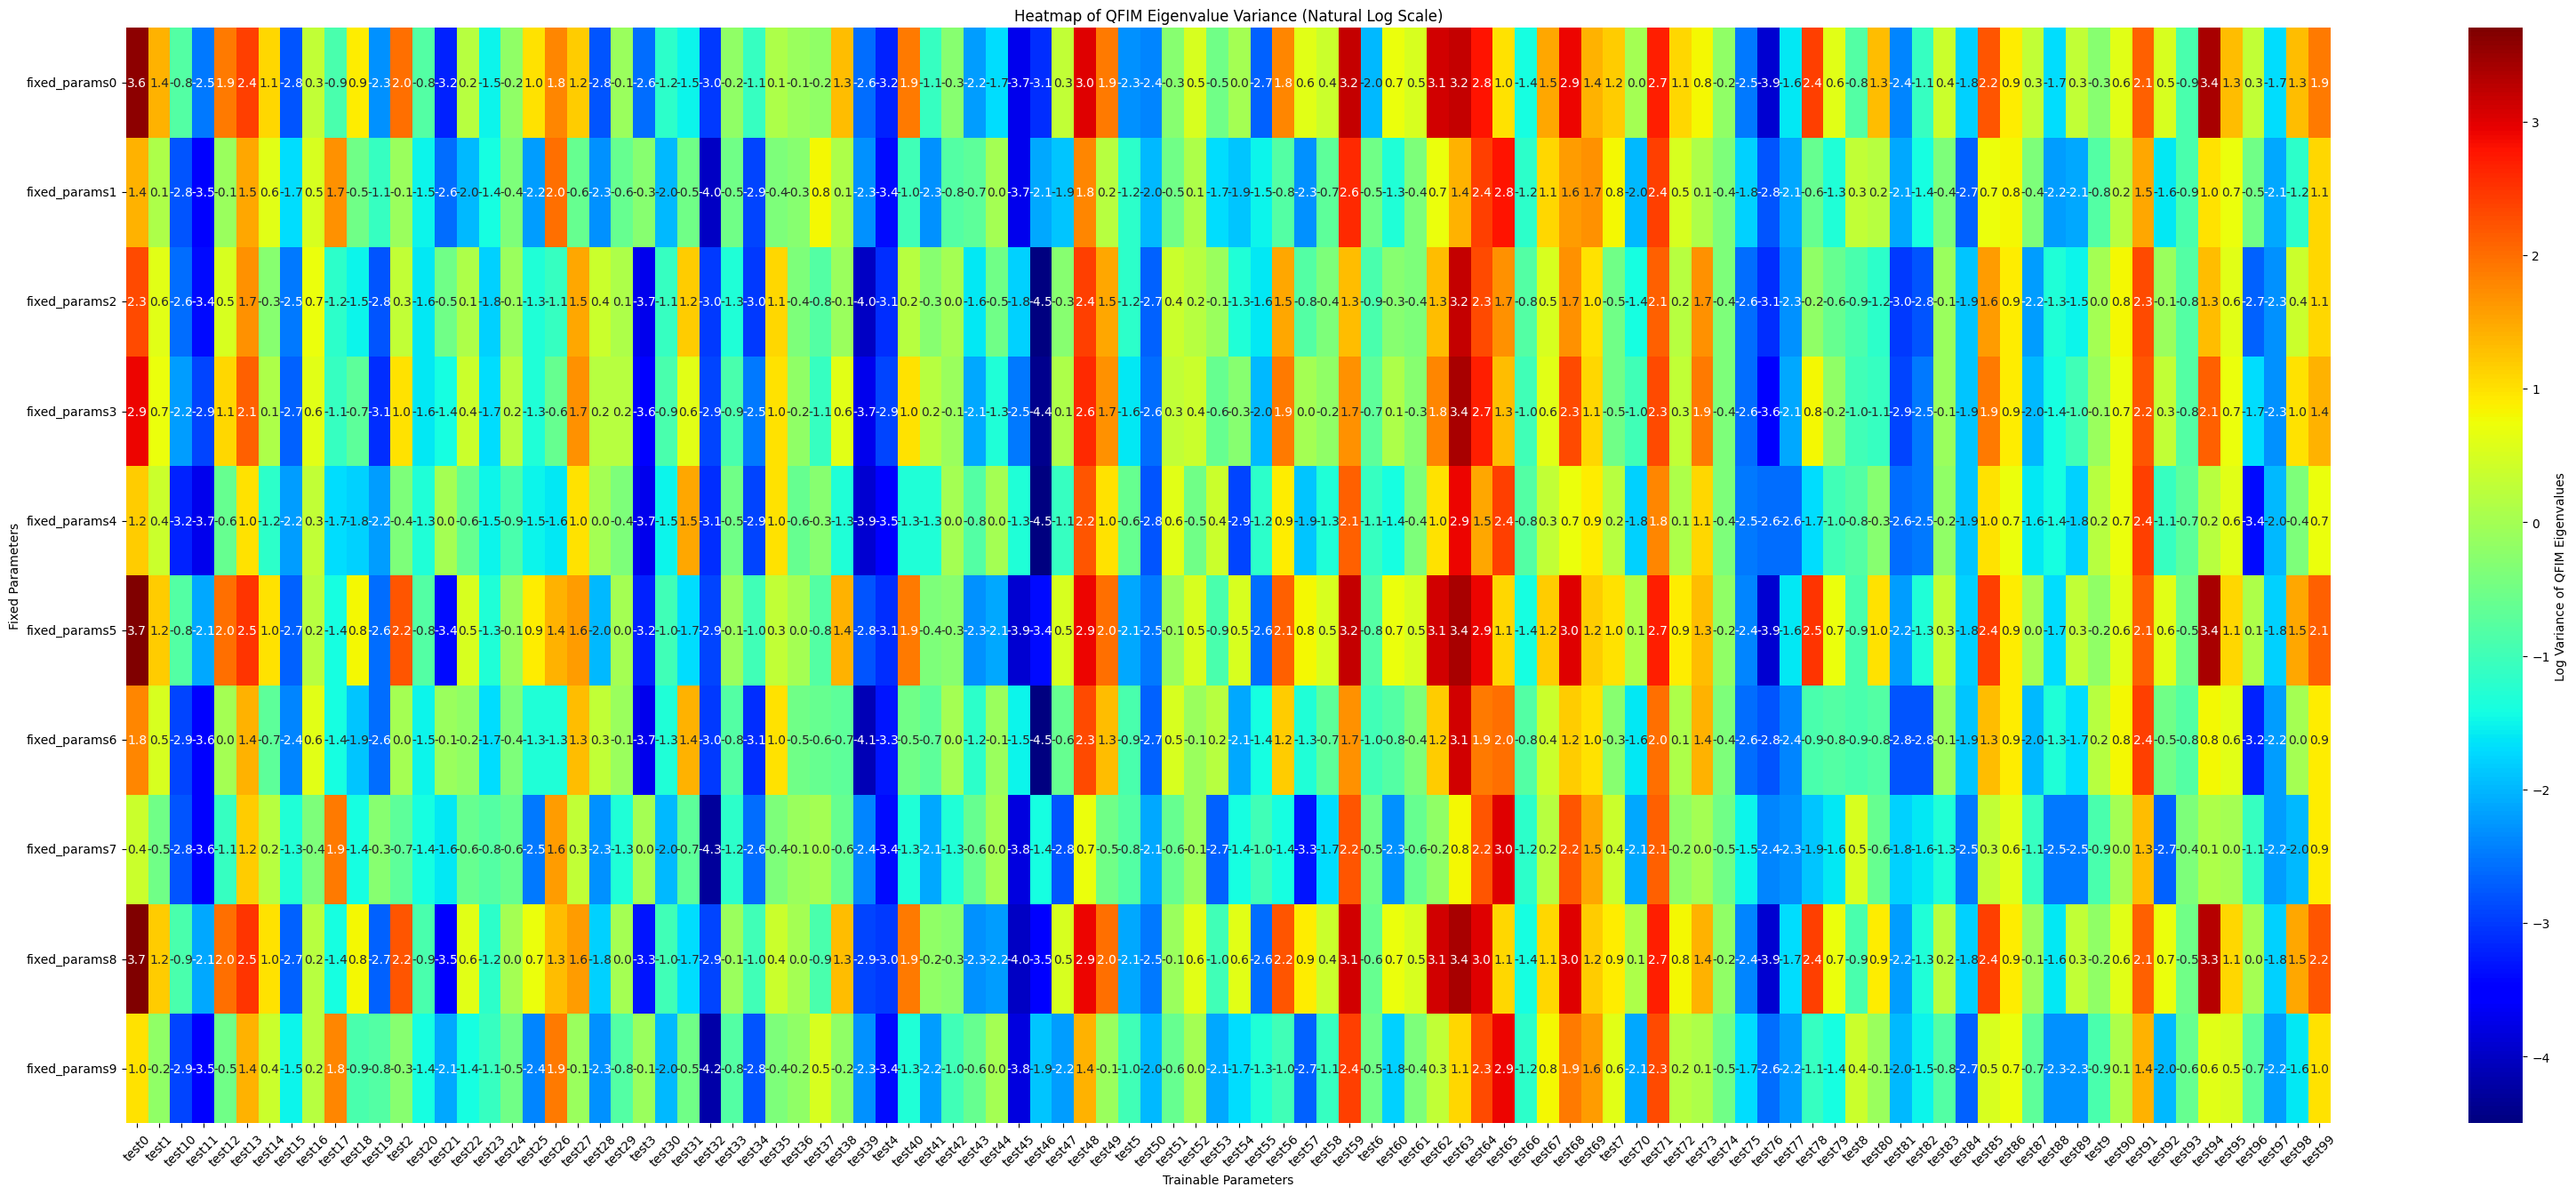

/var/folders/_n/l6510w3x7l7dl_qw6crm6t540000gr/T/ipykernel_2276/3133365799.py:72: FutureWarning: The provided callable <function mean at 0x107d6ae80> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Log Variance', aggfunc=np.mean)


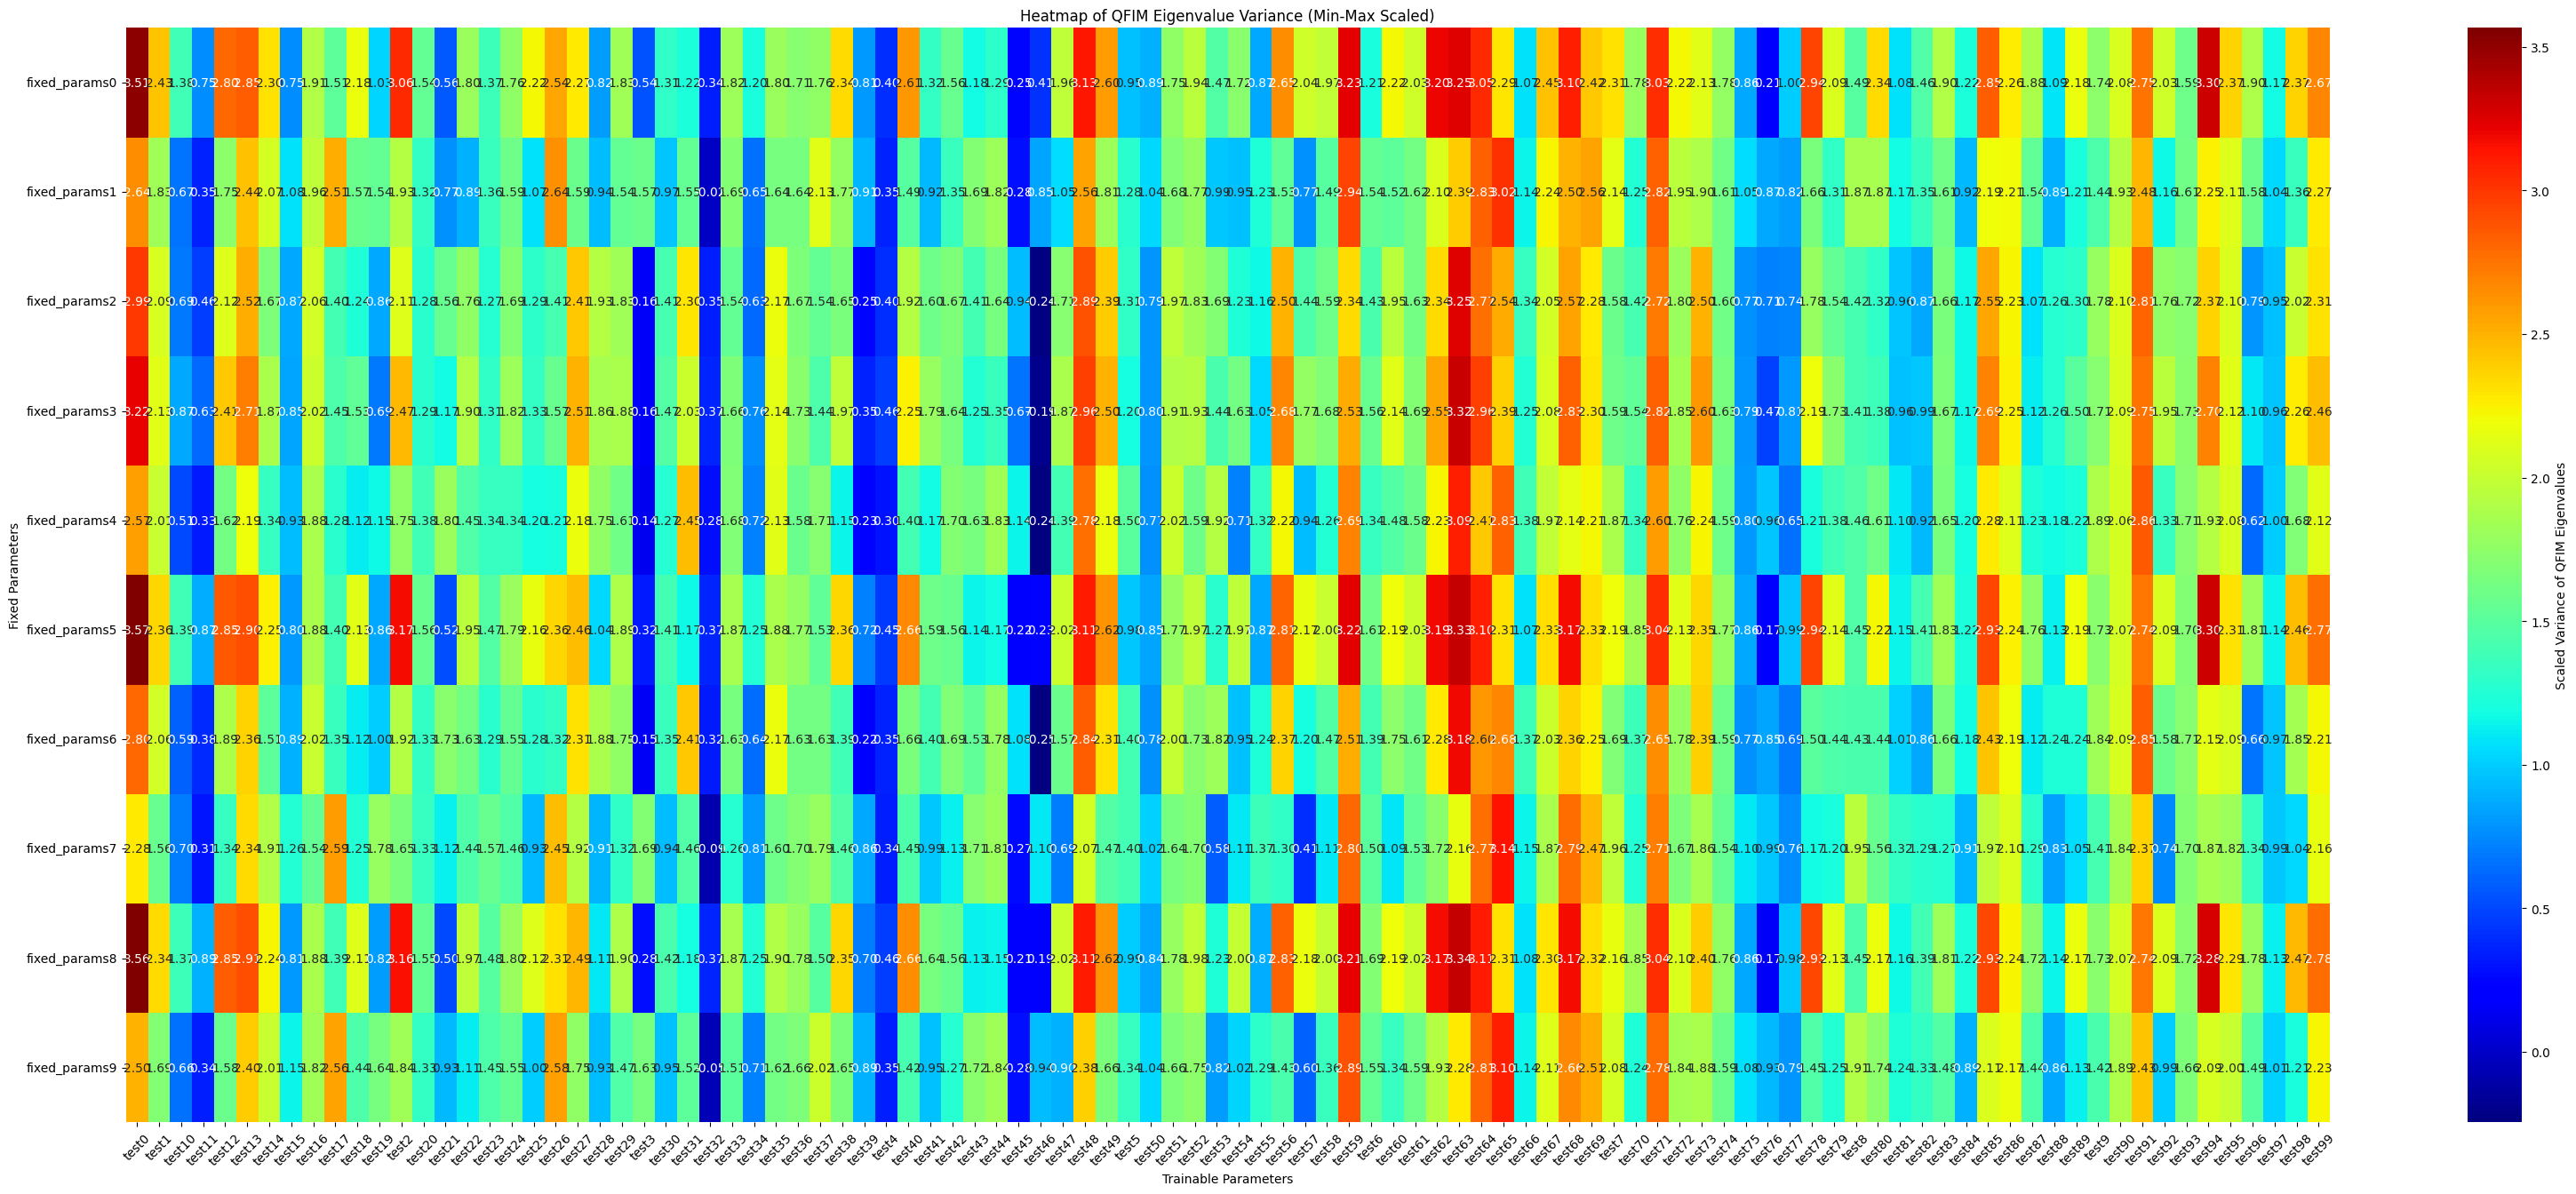

In [31]:
import seaborn as sns
def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        #if fixed_params_dict == 'fixed_params2':
        #    continue
        for trainable_params_dict in df[fixed_params_dict].keys():
            #if trainable_params_dict == 'test13' or trainable_params_dict == 'test14':
             #   continue
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict
def prepare_heatmap_data(qfim_eigvals_dict):
    """
    Prepare data for heatmap visualization.
    
    Parameters:
    - qfim_eigvals_dict: Dictionary containing QFIM eigenvalues.
    
    Returns:
    - DataFrame suitable for heatmap visualization.
    """
    heatmap_data = []
    
    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            variance = np.var(eigvals)
            if variance <= 0:
                variance = 1e-12  # Avoid log(0) by setting a small positive value
            log_variance = round(np.log(variance), 1)
            heatmap_data.append((fixed_param, trainable_param, log_variance))
    
    # Convert to DataFrame
    df_heatmap = pd.DataFrame(heatmap_data, columns=['Fixed Param', 'Trainable Param', 'Log Variance'])
    df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Log Variance', aggfunc=np.mean)
    
    return df_heatmap_pivot
def prepare_heatmap_data_trace(qfim_eigvals_dict):
    """
    Prepare data for heatmap visualization.
    
    Parameters:
    - qfim_eigvals_dict: Dictionary containing QFIM eigenvalues.
    
    Returns:
    - DataFrame suitable for heatmap visualization.
    """
    heatmap_data = []
    
    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            variance = np.sum(eigvals)
            
            log_variance = round(np.log(variance), 3)
            heatmap_data.append((fixed_param, trainable_param, log_variance))
    
    # Convert to DataFrame
    df_heatmap = pd.DataFrame(heatmap_data, columns=['Fixed Param', 'Trainable Param', 'Log Variance'])
    df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Log Variance', aggfunc=np.mean)
    
    return df_heatmap_pivot

def prepare_heatmap_data_minmax(qfim_eigvals_dict):
    heatmap_data = []
    variances = []

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        for trainable_param, eigvals in trainable_dict.items():
            variance = np.var(eigvals)
            variances.append(variance)
            heatmap_data.append((fixed_param, trainable_param, variance))

    min_variance = min(variances)
    max_variance = max(variances)
    scaled_heatmap_data = [(fp, tp, (var - min_variance) / (max_variance - min_variance)) for fp, tp, var in heatmap_data]
    
    df_heatmap = pd.DataFrame(scaled_heatmap_data, columns=['Fixed Param', 'Trainable Param', 'Scaled Variance'])
    
    # Ensure all data is numeric
    df_heatmap['Scaled Variance'] = df_heatmap['Scaled Variance'].astype(float)
    
    df_heatmap_pivot = df_heatmap.pivot_table(index='Fixed Param', columns='Trainable Param', values='Scaled Variance', aggfunc=np.mean)
    
    return df_heatmap_pivot


qfim_eigvals_dict = get_qfim_eigvals(file_path)
if qfim_eigvals_dict is not None:
    heatmap_data = prepare_heatmap_data(qfim_eigvals_dict)
    #print(heatmap_data.dtypes)
    # Create the heatmap
    plt.figure(figsize=(40, 16))  # Increase figsize for bigger cells
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='jet', cbar_kws={'label': 'Log Variance of QFIM Eigenvalues'})
    plt.title('Heatmap of QFIM Eigenvalue Variance (Natural Log Scale)')
    plt.xlabel('Trainable Parameters')
    plt.ylabel('Fixed Parameters')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

if qfim_eigvals_dict is not None:
    heatmap_data_minmax = prepare_heatmap_data_trace(qfim_eigvals_dict)
    
    
    # Create the heatmap
    plt.figure(figsize=(40, 16))  # Increase figsize for bigger cells
    sns.heatmap(heatmap_data_minmax, annot=True, fmt=".2f", cmap='jet', cbar_kws={'label': 'Scaled Variance of QFIM Eigenvalues'})
    plt.title('Heatmap of QFIM Eigenvalue Variance (Min-Max Scaled)')
    plt.xlabel('Trainable Parameters')
    plt.ylabel('Fixed Parameters')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [34]:

def get_qfim_eigvals(file_path):
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    qfim_eigvals_dict = {}
    for fixed_params_dict in df.keys():
        for trainable_params_dict in df[fixed_params_dict].keys():
            
            results = df[fixed_params_dict][trainable_params_dict]
            if 'qfim_eigvals' in results:
                qfim_eigvals = results['qfim_eigvals']
                if fixed_params_dict not in qfim_eigvals_dict:
                    qfim_eigvals_dict[fixed_params_dict] = {}
                qfim_eigvals_dict[fixed_params_dict][trainable_params_dict] = qfim_eigvals

    return qfim_eigvals_dict
def find_qfim_metrics_by_test(qfim_eigvals_dict, test_key, weight_mean=0.7, weight_range=0.3):
    """
    Find the trace and variance of the QFIM across all fixed parameter tests for a specific test key.

    Parameters:
    - qfim_eigvals_dict: Dictionary containing QFIM eigenvalues.
    - test_key: The specific test key to search for (e.g., 'test0').

    Returns:
    - Dictionary with trace and variance metrics.
    """
    trace_dict = {}
    variance_dict = {}

    for fixed_param, trainable_dict in qfim_eigvals_dict.items():
        if test_key in trainable_dict:
            eigvals = trainable_dict[test_key]
            trace = np.sum(eigvals)
            variance = np.var(eigvals)
            trace_dict[fixed_param] = trace
            variance_dict[fixed_param] = variance

    mean_trace = np.mean(list(trace_dict.values()))
    mean_variance = np.mean(list(variance_dict.values()))
    range_trace = max(trace_dict.values()) - min(trace_dict.values())
    range_variance = max(variance_dict.values()) - min(variance_dict.values())

    weighted_avg_trace = weight_mean * mean_trace + weight_range * range_trace
    weighted_avg_variance = weight_mean * mean_variance + weight_range * range_variance

    return {
        "trace_dict": trace_dict,
        "variance_dict": variance_dict,
        "mean_trace": mean_trace,
        "mean_variance": mean_variance,
        "range_trace": range_trace,
        "range_variance": range_variance,
        "weighted_avg_trace": weighted_avg_trace,
        "weighted_avg_variance": weighted_avg_variance
    }



qfim_eigvals_dict = get_qfim_eigvals(file_path)
# Example usage
# Example usage
test_key = 'test65'
if qfim_eigvals_dict is not None:
    test_metrics = find_qfim_metrics_by_test(qfim_eigvals_dict, test_key)
    print(f"Trace metrics for {test_key}: {test_metrics['trace_dict']}")
    print(f"Variance metrics for {test_key}: {test_metrics['variance_dict']}")
    print(f"Mean trace for {test_key}: {test_metrics['mean_trace']}, range: {test_metrics['range_trace']}")
    print(f"Mean variance for {test_key}: {test_metrics['mean_variance']}, range: {test_metrics['range_variance']}")

    print(f"Weighted average trace for {test_key}: {test_metrics['weighted_avg_trace']}")
    print(f"Weighted average variance for {test_key}: {test_metrics['weighted_avg_variance']}")

    # Finding the fixed parameter with the smallest and largest trace and variance
    min_trace_fixed_param = min(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    max_trace_fixed_param = max(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    min_variance_fixed_param = min(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)
    max_variance_fixed_param = max(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)

    print(f"\nsmallest trace for {test_key}: {min_trace_fixed_param}, Trace: {test_metrics['trace_dict'][min_trace_fixed_param]}")
    print(f"largest trace for {test_key}: {max_trace_fixed_param}, Trace: {test_metrics['trace_dict'][max_trace_fixed_param]}")
    print(f"smallest variance for {test_key}: {min_variance_fixed_param}, Variance: {test_metrics['variance_dict'][min_variance_fixed_param]}")
    print(f"largest variance for {test_key}: {max_variance_fixed_param}, Variance: {test_metrics['variance_dict'][max_variance_fixed_param]}")

Trace metrics for test65: {'fixed_params0': Array(14.922232, dtype=float32), 'fixed_params1': Array(7.5507975, dtype=float32), 'fixed_params2': Array(11.381183, dtype=float32), 'fixed_params3': Array(15.181354, dtype=float32), 'fixed_params4': Array(10.338419, dtype=float32), 'fixed_params5': Array(13.182128, dtype=float32), 'fixed_params6': Array(10.0645, dtype=float32), 'fixed_params7': Array(8.524782, dtype=float32), 'fixed_params8': Array(10.500038, dtype=float32), 'fixed_params9': Array(11.375399, dtype=float32)}
Variance metrics for test65: {'fixed_params0': Array(1.4045855, dtype=float32), 'fixed_params1': Array(0.14814086, dtype=float32), 'fixed_params2': Array(0.6599972, dtype=float32), 'fixed_params3': Array(1.5402452, dtype=float32), 'fixed_params4': Array(0.54815125, dtype=float32), 'fixed_params5': Array(1.1167301, dtype=float32), 'fixed_params6': Array(0.43212363, dtype=float32), 'fixed_params7': Array(0.25307137, dtype=float32), 'fixed_params8': Array(0.5339928, dtype=fl

In [18]:
test_key = 'test92'
if qfim_eigvals_dict is not None:
    test_metrics = find_qfim_metrics_by_test(qfim_eigvals_dict, test_key)
    print(f"Trace metrics for {test_key}: {test_metrics['trace_dict']}")
    print(f"Variance metrics for {test_key}: {test_metrics['variance_dict']}")
    print(f"Mean trace for {test_key}: {test_metrics['mean_trace']}, range: {test_metrics['range_trace']}")
    print(f"Mean variance for {test_key}: {test_metrics['mean_variance']}, range: {test_metrics['range_variance']}")

    print(f"Weighted average trace for {test_key}: {test_metrics['weighted_avg_trace']}")
    print(f"Weighted average variance for {test_key}: {test_metrics['weighted_avg_variance']}")

    # Finding the fixed parameter with the smallest and largest trace and variance
    min_trace_fixed_param = min(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    max_trace_fixed_param = max(test_metrics['trace_dict'], key=test_metrics['trace_dict'].get)
    min_variance_fixed_param = min(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)
    max_variance_fixed_param = max(test_metrics['variance_dict'], key=test_metrics['variance_dict'].get)

    print(f"\nsmallest trace for {test_key}: {min_trace_fixed_param}, Trace: {test_metrics['trace_dict'][min_trace_fixed_param]}")
    print(f"largest trace for {test_key}: {max_trace_fixed_param}, Trace: {test_metrics['trace_dict'][max_trace_fixed_param]}")
    print(f"smallest variance for {test_key}: {min_variance_fixed_param}, Variance: {test_metrics['variance_dict'][min_variance_fixed_param]}")
    print(f"largest variance for {test_key}: {max_variance_fixed_param}, Variance: {test_metrics['variance_dict'][max_variance_fixed_param]}")

Trace metrics for test92: {'fixed_params0': Array(6.771572, dtype=float32), 'fixed_params1': Array(16.828123, dtype=float32), 'fixed_params2': Array(16.753378, dtype=float32), 'fixed_params3': Array(13.8496, dtype=float32), 'fixed_params4': Array(9.207301, dtype=float32), 'fixed_params5': Array(12.017764, dtype=float32), 'fixed_params6': Array(16.29683, dtype=float32), 'fixed_params7': Array(10.435121, dtype=float32), 'fixed_params8': Array(8.366361, dtype=float32), 'fixed_params9': Array(10.485873, dtype=float32)}
Variance metrics for test92: {'fixed_params0': Array(0.09240144, dtype=float32), 'fixed_params1': Array(1.9980239, dtype=float32), 'fixed_params2': Array(2.1454182, dtype=float32), 'fixed_params3': Array(1.3178831, dtype=float32), 'fixed_params4': Array(0.32682627, dtype=float32), 'fixed_params5': Array(0.8169702, dtype=float32), 'fixed_params6': Array(1.9606341, dtype=float32), 'fixed_params7': Array(0.51811415, dtype=float32), 'fixed_params8': Array(0.31166345, dtype=float